# Try SSLEM
Running the SSLEM example script from pyechomask.

### SSLEM.py
# Setup
Sound Scattering Layer Extraction Method (SSLEM) example
desc: Extract sound scattering layers from echograms 
Reference:
Proud R, Cox MJ, Wotherspoon S, Brierley AS. 
A method for identifying Sound Scattering Layers and extracting key characteristics. 
Methods Ecol Evol 2015;6:1190–8. doi:10.1111/2041-210X.12396.
example by: Roland Proud (RP) <rp43@st-andrews.ac.uk> 
            Pelagic Ecology Research Group, University of St Andrews
Modification History:
'''

In [5]:
## import packages
import matplotlib.pyplot as plt
import gzip
import pickle
import echopype as ep
import numpy as np
from pyechoplot.plotting import plot_Sv, plot_mask, save_png_plot

## import pyechomask modules
from pyechomask.masks import binary_seabed, binary_signal
from pyechomask.manipulate import  signal_row_filter, signal_column_filter, flag,\
        vertical_merge,feature_median, fill_feature_gaps, break_mask, remove_features

I modified a function because I was gettting a bug. Should be just plot_mask, adapted to plot_mask_fis for colourmap.

In [2]:
## Bug fix for missing colourmap
def plot_mask_fix(mask):
    '''
    plot mask (any - binary/flag/continuous)
    '''
    ## shape
    row,col = mask.shape
    
    ## plot
    #f, (ax1) = plt.subplots(1, figsize = (20,10))
    p1       = plt.imshow(mask, cmap = plt.cm.nipy_spectral,\
            interpolation='nearest',aspect='auto')
    plt.colorbar(p1,pad = 0)
    plt.xlabel('columns',fontsize = 18)
    plt.ylabel('rows',fontsize = 18)

In [3]:
## get Sv data
def getSv(filepath):
    f   = gzip.open(filepath,'rb')
    obj = pickle.load(f,encoding = 'bytes')
    f.close()
    return obj

In [6]:
fname = 'D:/GLIDER2018/Echosounder/Echosounder/nc_files/GLIDER_SB_2018_v5-Phase0-D20180625-T170658-1.nc'
ed = ep.open_converted(fname)
ds = ep.calibrate.compute_Sv(ed, waveform_mode='BB', encode_mode='complex')
Sv = np.array(ds.Sv.isel(frequency=0)).T

<string>:6: DeprecationWarning: `np.alen` is deprecated, use `len` instead


In [7]:
Sv.shape

(25296, 173)

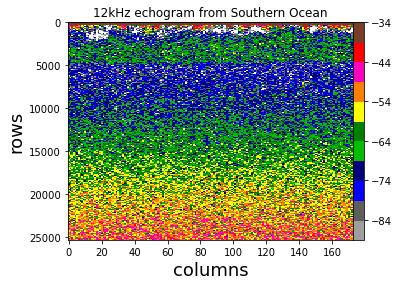

In [8]:
plot_Sv(Sv)
plt.title('12kHz echogram from Southern Ocean')
plt.show()

In [26]:
## Sv observation parameters
noise_level   = -70   # background noise level (dB re 1m^-1)
sample_int    = 0.006    # sample interval (m)
pl            = 1.384 # pulse length (ms)
fq            = 333   # Frequency

## SSLEM optimization parameters (recomended setting for regional analysis)
min_sep       = 5     # minimum SSL seperation (m):min = pulse length
max_thickness = 30    # Maximun SSL thickness  (m)
min_size      = 15  # Minimum duration of SSL (pings)
min_thickness = 2     # Minimun thickness of SSL (m)

## thresholds 
minSv = -70
maxSv = -50

# SSLEM
#### NOTE: the order of these steps is important

In [27]:
## calculate number of rows/samples from meters
min_thickness_rows = int(min_thickness/sample_int)
min_sep_rows       = int(min_sep/sample_int)


In [28]:
## remove pulse 
Sv[0:100,:] = noise_level  

## remove weak signal
Sv[Sv < minSv] = noise_level

## get seabed mask, window_size refers to a rolling median filter
## seabed mask in development - check
seabed_mask, seabed_idx = binary_seabed(Sv,buffer = min_sep_rows,window_size = 10)

C:\Users\mbd\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


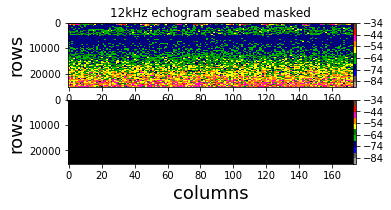

In [29]:
## plot
plt.figure()
plt.subplot(311)
plot_Sv(Sv)
plt.title('12kHz echogram seabed masked')
plt.subplot(312)
plot_Sv(Sv,mask = seabed_mask)
plt.show()


## SSLEM: identify signal pixels

In [30]:
## this step is the bottle neck
signal_mask = binary_signal(Sv,pl,sample_int,min_sep,max_thickness,max_steps = 10)

C:\Users\mbd\anaconda3\lib\site-packages\pyechomask-1.0.0.dev5-py3.7.egg\pyechomask\masks.py:140: RuntimeWarning: invalid value encountered in greater
  sig = (linear > np.ma.median(mu1,axis = 0)) * \
C:\Users\mbd\anaconda3\lib\site-packages\pyechomask-1.0.0.dev5-py3.7.egg\pyechomask\masks.py:141: RuntimeWarning: invalid value encountered in greater
  (linear > np.ma.median(mu2,axis = 0))  ## where pixel value greater then both upper mean and lower mean then classify as signal


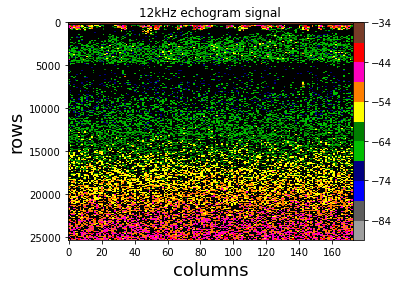

In [31]:
## plot
plt.figure()
plot_Sv(Sv,mask = signal_mask)
plt.title('12kHz echogram signal')
plt.show()
   

#### row smooth signal mask:

In [12]:
## where majority (threshold = 0.5) pixels are signal make all signal, otherwise label all noise
signal = signal_row_filter(signal_mask,min_size,threshold = 0.5) 
   
## remove SSLs that are too thin
signal = signal_column_filter(signal,min_thickness_rows,threshold = 1)

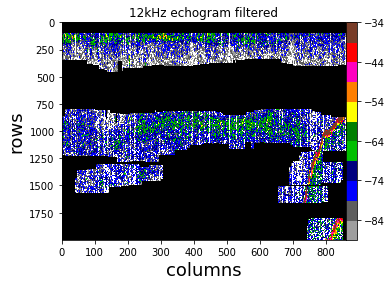

In [13]:
## plot
plt.figure()
plot_Sv(Sv,mask = signal)
plt.title('12kHz echogram filtered')
plt.show()
  

In [14]:
## label SSls (flag) and remove small SSLs (size < min_size*min_thickness_rows)
signal = flag(signal,min_size*min_thickness_rows)

## merge SSLs that are closer together than the min seperation
signal[signal > 0] = 1
signal             = vertical_merge(signal,min_sep_rows)

## fill internal gaps - max size = min_size*min_thickness_rows
signal = fill_feature_gaps(signal,min_size*min_thickness_rows)

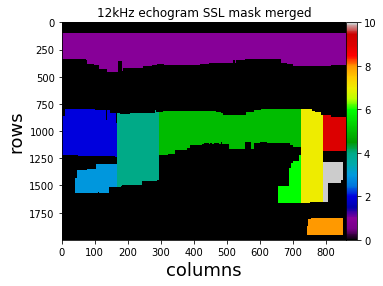

In [21]:
## plot
plt.figure()
plot_mask_fix(signal)
plt.title('12kHz echogram SSL mask merged')
plt.show()

In [22]:
## break merged SSLs into individual SSLs
signal = break_mask(signal)

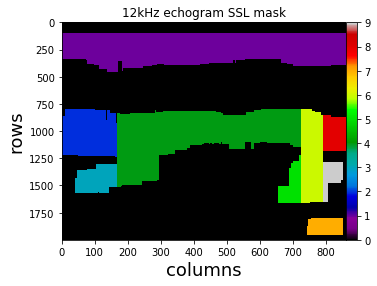

In [23]:
## plot
plt.figure()
plot_mask_fix(signal)
plt.title('12kHz echogram SSL mask')
plt.show()

In [24]:
## remove small SSLs
signal = remove_features(signal.astype(int),min_size*min_thickness_rows)

## get median values of each SSL
Sv_median = feature_median(Sv,signal)

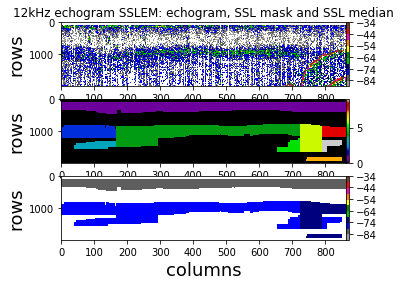

In [25]:
## plot
plt.figure()
plt.subplot(311)
plot_Sv(Sv)
plt.title('12kHz echogram SSLEM: echogram, SSL mask and SSL median')
plt.subplot(312)
plot_mask_fix(signal) 
plt.subplot(313)
plot_Sv(Sv_median)  
plt.show()
#save_png_plot('./plots/','SSLEMexample')